<a href="https://colab.research.google.com/github/Alexander1718/UIDAI-HACKATHON/blob/main/02_feature_engineering_ASRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os
import pandas as pd
from glob import glob


In [ ]:
os.makedirs("data", exist_ok=True)

for z in [f for f in os.listdir() if f.endswith(".zip")]:
    with zipfile.ZipFile(z, 'r') as zip_ref:
        zip_ref.extractall("data")


In [ ]:
def load_all_csvs(folder):
    return pd.concat(
        [pd.read_csv(f) for f in glob(folder + "/**/*.csv", recursive=True)],
        ignore_index=True
    )

biometric_df   = load_all_csvs("data/api_data_aadhar_biometric")
demographic_df = load_all_csvs("data/api_data_aadhar_demographic")
enrolment_df   = load_all_csvs("data/api_data_aadhar_enrolment")

for df in [biometric_df, demographic_df, enrolment_df]:
    df.columns = df.columns.str.lower()


In [ ]:
from collections import defaultdict

KEYS = ['state', 'district', 'pincode']


In [ ]:
def aggregate_large_csvs(folder, value_columns):
    agg_store = defaultdict(lambda: defaultdict(float))

    csv_files = glob(folder + "/**/*.csv", recursive=True)

    for file in csv_files:
        for chunk in pd.read_csv(file, chunksize=100_000):
            chunk.columns = chunk.columns.str.lower()
            chunk = chunk.dropna(subset=KEYS)

            for _, row in chunk.iterrows():
                key = tuple(row[k] for k in KEYS)
                for col in value_columns:
                    agg_store[key][col] += row.get(col, 0)

    records = []
    for key, values in agg_store.items():
        record = dict(zip(KEYS, key))
        record.update(values)
        records.append(record)

    return pd.DataFrame(records)


In [ ]:
biometric_df = aggregate_large_csvs(
    "data/api_data_aadhar_biometric",
    value_columns=['bio_age_5_17']
)


In [ ]:
demographic_df = aggregate_large_csvs(
    "data/api_data_aadhar_demographic",
    value_columns=['demo_age_5_17', 'demo_age_17_', 'age_18_greater']
)

demographic_df = demographic_df.rename(
    columns={'age_18_greater': 'age_18_plus_demo'}
)


In [ ]:
enrolment_df = aggregate_large_csvs(
    "data/api_data_aadhar_enrolment",
    value_columns=['age_5_17', 'age_18_greater']
)

enrolment_df = enrolment_df.rename(
    columns={'age_18_greater': 'age_18_plus_enrol'}
)


In [ ]:
KEYS = ['state', 'district', 'pincode']

master_df = biometric_df.merge(
    demographic_df, on=KEYS, how='inner'
).merge(
    enrolment_df, on=KEYS, how='inner'
)


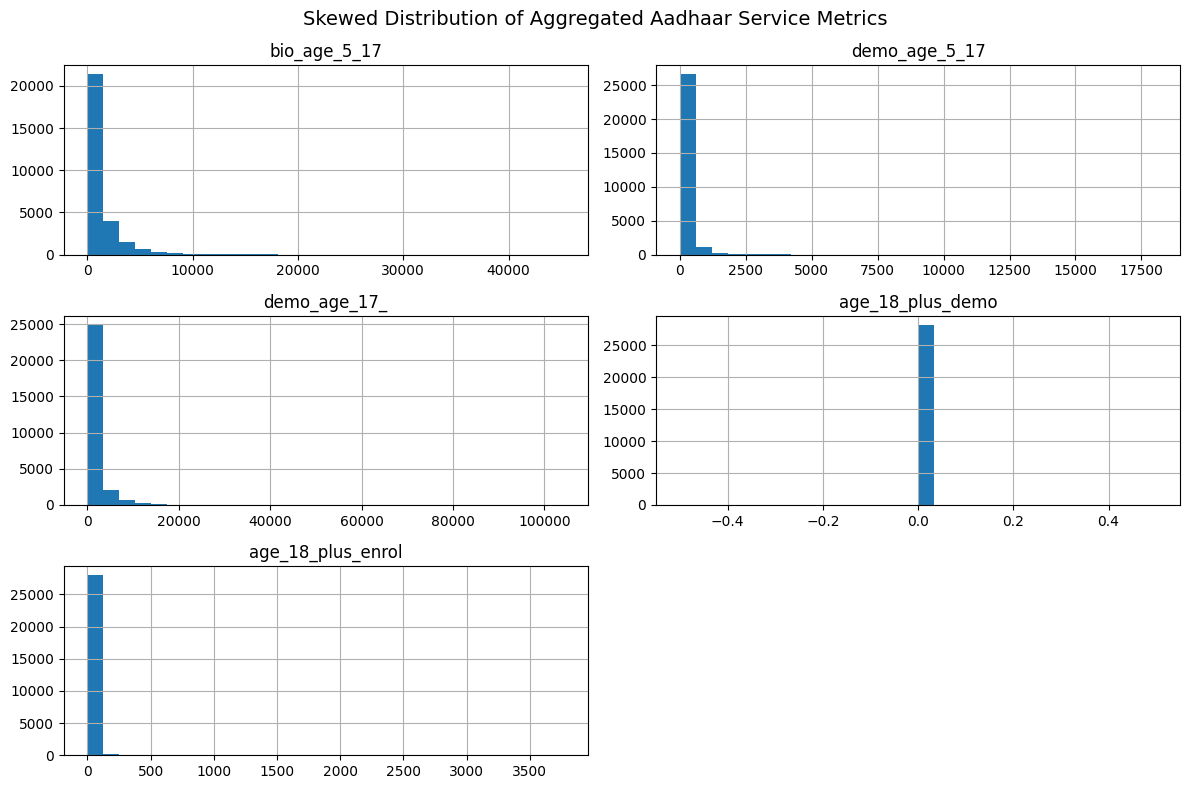

In [ ]:
import matplotlib.pyplot as plt

features = [
    'bio_age_5_17',
    'demo_age_5_17',
    'demo_age_17_',
    'age_18_plus_demo',
    'age_18_plus_enrol'
]

master_df[features].hist(
    figsize=(12, 8),
    bins=30
)

plt.suptitle(
    "Skewed Distribution of Aggregated Aadhaar Service Metrics",
    fontsize=14
)
plt.tight_layout()
plt.show()


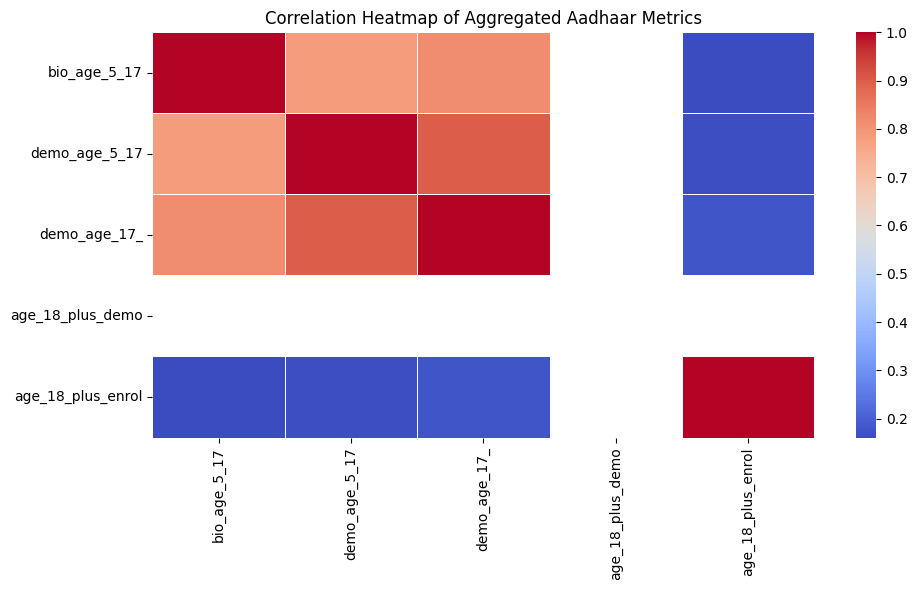

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(
    master_df[features].corr(),
    cmap="coolwarm",
    annot=False,
    linewidths=0.5
)

plt.title("Correlation Heatmap of Aggregated Aadhaar Metrics")
plt.tight_layout()
plt.show()


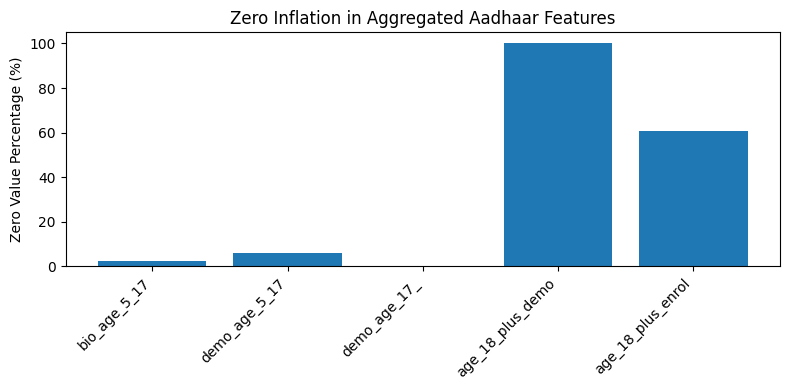

In [ ]:
zero_ratio = (master_df[features] == 0).mean() * 100

plt.figure(figsize=(8, 4))
plt.bar(zero_ratio.index, zero_ratio.values)

plt.ylabel("Zero Value Percentage (%)")
plt.title("Zero Inflation in Aggregated Aadhaar Features")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
master_df['age_18_greater'] = master_df['age_18_plus_demo']


In [ ]:
master_df.fillna(0, inplace=True)


In [ ]:
master_df['service_dependency'] = (
    master_df['demo_age_5_17'] + master_df['demo_age_17_']
) / (master_df['age_18_greater'] + 1)

master_df['service_fragility'] = (
    master_df['bio_age_5_17']
) / (master_df['demo_age_5_17'] + 1)

master_df['demographic_sensitivity'] = (
    master_df['age_5_17']
) / (master_df['age_18_greater'] + 1)

master_df['ASRI'] = (
    master_df['service_dependency'] *
    master_df['service_fragility'] *
    master_df['demographic_sensitivity']
)

master_df[['state','district','pincode','ASRI']].sort_values(
    'ASRI', ascending=False
).head(10)


,state,district,pincode,ASRI
16676,Uttar Pradesh,Aligarh,202001,2.675547e+09
4914,Uttar Pradesh,Moradabad,244001,2.368554e+09
16953,Uttar Pradesh,Meerut,250002,1.336826e+09
16991,Uttar Pradesh,Rampur,244901,1.275605e+09
1822,Uttar Pradesh,Shahjahanpur,242001,1.260125e+09
4778,Uttar Pradesh,Firozabad,283203,1.184351e+09
6512,Uttar Pradesh,Saharanpur,247001,1.178778e+09
14115,Uttar Pradesh,Unnao,209801,1.076243e+09
16728,Uttar Pradesh,Bahraich,271865,8.181024e+08
17044,Uttar Pradesh,Varanasi,221001,8.019301e+08


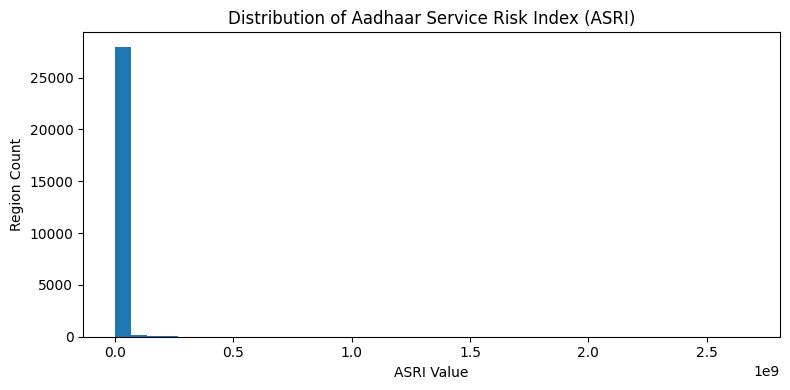

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(master_df['ASRI'], bins=40)

plt.xlabel("ASRI Value")
plt.ylabel("Region Count")
plt.title("Distribution of Aadhaar Service Risk Index (ASRI)")
plt.tight_layout()
plt.show()


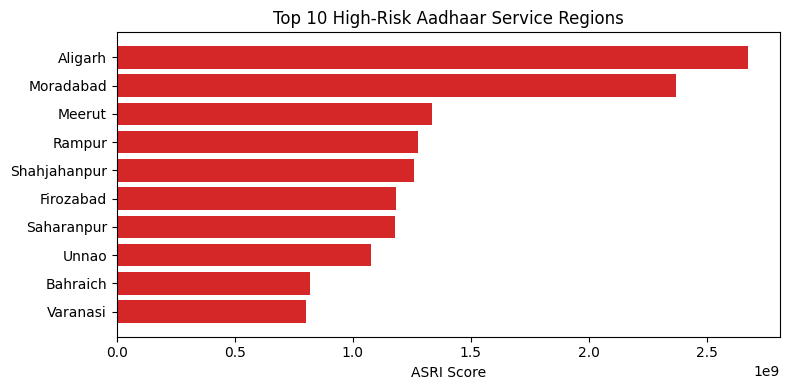

In [ ]:
top_asri = master_df.sort_values("ASRI", ascending=False).head(10)

plt.figure(figsize=(8, 4))
plt.barh(
    top_asri['district'],
    top_asri['ASRI'],
    color="#d62728"
)

plt.xlabel("ASRI Score")
plt.title("Top 10 High-Risk Aadhaar Service Regions")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


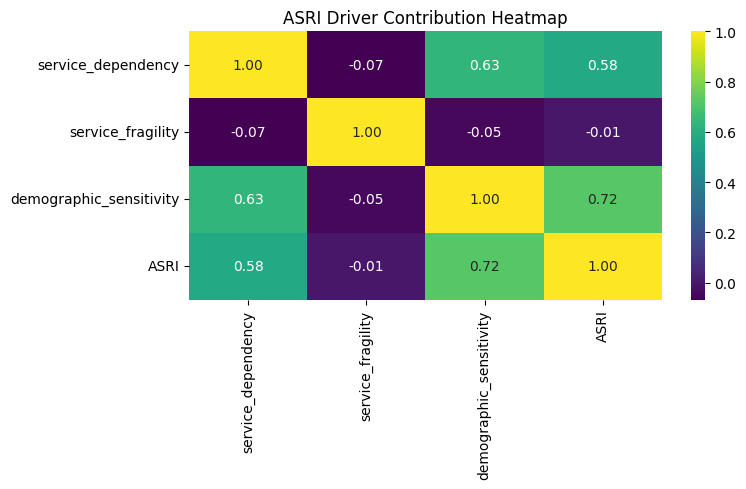

In [ ]:
driver_cols = [
    'service_dependency',
    'service_fragility',
    'demographic_sensitivity',
    'ASRI'
]

plt.figure(figsize=(8, 5))
sns.heatmap(
    master_df[driver_cols].corr(),
    cmap="viridis",
    annot=True,
    fmt=".2f"
)

plt.title("ASRI Driver Contribution Heatmap")
plt.tight_layout()
plt.show()
